<left>
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Logo_SYGNET.png" width="90" alt="cognitiveclass.ai logo">
</left>

<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Tensorflow_logo.svg" width="200" alt="cognitiveclass.ai logo">
</center>




# A.I. Dataset

Postprocessing the simulation results from ZSOIL for Neural Network training.

## Objectives

To import, clean, interpolate and combine the results of ZSOIL model simulation into one Dataset. The operations involve:

*   Data Science with Python
*   Statistics

In [2]:
!pip install statsmodels

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm

print(scipy.__version__)

1.14.0


### 1. Loading Data from ZSOIL

We read CSV files into Python <i>DataFrames</i>. The column names and data locations in CSV files have to match the expected format in the code. We then check the structure of the loaded data by printing first few rows and columns for verification.

In [3]:
# Load your data with the correct delimiter
nodal_data = pd.read_csv('nodal.csv', delimiter=';')
element_data = pd.read_csv('element.csv', delimiter=';', skiprows=1)

# Print column names and first few rows
print("Nodal Data Columns and First Few Rows:")
print(nodal_data.columns)
print(nodal_data.head())

print("\nElement Data Columns and First Few Rows:")
print(element_data.columns)
print(element_data.head())

Nodal Data Columns and First Few Rows:
Index(['        TIME', '      SF', 'PUSHOVER LABEL', 'PUSHOVER LAMBDA',
       'PUSHOVER U-CTRL', 'ARC LENGTH STEP', 'ARC LENGTH U-NORM',
       'ARC LENGTH LOAD FACTOR', '      NR', '           X', '           Y',
       'Displacement-X', 'Displacement-Y', '  Rotation-Z', 'Pore pressure-',
       ' Total head-', 'Residual Force-X', 'Residual Force-Y',
       'Residual Heat flux-Z', 'Solid-Velocity-X', 'Solid-Velocity-Y',
       'Solid-Acceleration-X', 'Solid-Acceleration-Y', 'Unnamed: 23'],
      dtype='object')
           TIME            SF PUSHOVER LABEL PUSHOVER LAMBDA PUSHOVER U-CTRL  \
0         [day]                                                          [m]   
1  0.000000e+00  0.000000e+00            NaN    0.000000e+00    0.000000e+00   
2  0.000000e+00  0.000000e+00            NaN    0.000000e+00    0.000000e+00   
3  0.000000e+00  0.000000e+00            NaN    0.000000e+00    0.000000e+00   
4  0.000000e+00  0.000000e+00            N

### 2. Renaming Columns for Consistency

After loading the data, the 'X' and 'Y' columns are renamed in both datasets to facilitate easy referencing and alignment.

In [4]:
# Renaming the X and Y columns in both datasets for consistency
element_data.rename(columns={
    element_data.columns[10]: 'X', 
    element_data.columns[11]: 'Y'
}, inplace=True)

nodal_data.rename(columns={
    nodal_data.columns[9]: 'X', 
    nodal_data.columns[10]: 'Y'
}, inplace=True)

### 3. Cleaning and Converting

We can loop through the columns and check for any non-numeric values that should be numeric. The Helper Function <i>can_convert_to_float</i> tries to convert each value to a float and returns <b>True</b> if successful, <b>False</b> otherwise. Then Cleaning Loop goes through each column, checks if it is of type object (which might include malformed strings), and attempts to convert them to float. If conversion fails, the value is replaced with <i>NaN</i>.

In [6]:
# Function to check if a string can be converted to a float
def can_convert_to_float(value):
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

# Function to clean and convert the DataFrame
def clean_and_convert(df):
    df = df.copy()  # Avoid SettingWithCopyWarning by working with a copy
    for column in df.columns:
        if df[column].dtype == 'object':  # Check if the column is object type
            # Convert columns to numeric, coerce errors to NaN
            df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Apply the cleaning to nodal and element data
nodal_data_clean = clean_and_convert(nodal_data)
element_data_clean = clean_and_convert(element_data)

# Optional: Handle NaN values
nodal_data_clean.fillna(0, inplace=True)
element_data_clean.fillna(0, inplace=True)

In [7]:
print("Nodal Data Clean:")
print(nodal_data_clean[['X', 'Y']].describe())

print("Element Data Clean:")
print(element_data_clean.describe())

print("First few rows of nodal_data_clean:")
print(nodal_data_clean[['X', 'Y']].head())

print("First few rows of element_data_clean:")
print(element_data_clean.head())

Nodal Data Clean:
                  X             Y
count  1.597300e+04  15973.000000
mean   6.213293e+01    -19.133468
std    3.637416e+01     11.953250
min   -1.421085e-14    -40.000000
25%    3.091176e+01    -28.734920
50%    6.500284e+01    -19.013870
75%    8.984375e+01     -9.125497
max    1.250000e+02      0.000000
Element Data Clean:
               TIME        SF  PUSHOVER LABEL  PUSHOVER LAMBDA  \
count  14874.000000   14874.0         14874.0          14874.0   
mean       1.999462       0.0             0.0              0.0   
std        1.414451       0.0             0.0              0.0   
min        0.000000       0.0             0.0              0.0   
25%        1.000000       0.0             0.0              0.0   
50%        2.000000       0.0             0.0              0.0   
75%        3.000000       0.0             0.0              0.0   
max        4.000000       0.0             0.0              0.0   

       PUSHOVER U-CTRL  ARC LENGTH STEP  ARC LENGTH U-NORM  \

### 4. Nearest Neighbor Interpolation Logic

To prepare data for future neural network operations, interpolation should be handled carefully to preserve the structure and continuity of the data. In this context, we can use interpolation methods such as <b>Nearest Neighbour</b> or <b>Bilinear Interpolation</b>. Here's an example using nearest neighbor interpolation since it's simple and works well for many cases, especially if your data points are not uniformly distributed. The element data is averaged based on proximity to nodal points, which helps generate interpolated data at the nodal locations.

In [8]:
# Interpolate element data to nodal points without filtering or deduplication
from scipy.spatial import cKDTree

def interpolate_element_data_to_nodal(nodal_coords, element_data_clean):
    # Prepare the KDTree for fast nearest-neighbor lookup
    element_tree = cKDTree(element_data_clean[['X', 'Y']].values)

    # Find the nearest element point for each nodal point
    distances, indices = element_tree.query(nodal_coords[['X', 'Y']].values)

    # Retrieve the corresponding element data for the nearest points
    element_data_interpolated = element_data_clean.iloc[indices].reset_index(drop=True)
    
    return element_data_interpolated

# Perform the interpolation
element_data_interpolated = interpolate_element_data_to_nodal(nodal_data_clean[['X', 'Y']], element_data_clean)

# Merge nodal data with interpolated element data without filtering by TIME or removing duplicates
combined_data = pd.concat(
    [nodal_data_clean.reset_index(drop=True), 
     element_data_interpolated.drop(columns=['X', 'Y'])], axis=1)

# Check the result
print("Combined Data Shape (After Interpolation and Concatenation):", combined_data.shape)

Combined Data Shape (After Interpolation and Concatenation): (15973, 83)


### 6. Visualize the Coordinate Ranges

We plot the <b>X</b> and <b>Y</b> coordinates from both datasets to visually inspect their ranges and distributions. This can reveal if the datasets are completely disjoint, or if there's just a slight shift or misalignment.

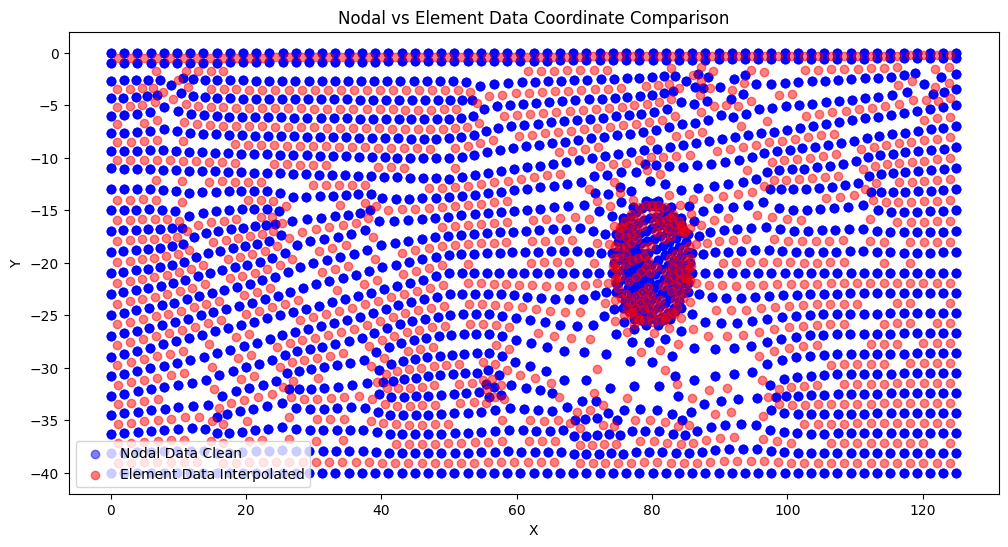

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot nodal data
plt.scatter(nodal_data_clean['X'], nodal_data_clean['Y'], color='blue', label='Nodal Data Clean', alpha=0.5)

# Plot element data
plt.scatter(element_data_interpolated['X'], element_data_interpolated['Y'], color='red', label='Element Data Interpolated', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Nodal vs Element Data Coordinate Comparison')

# Save the plot
plt.savefig('Nodal vs Element data coordinate comparison.png')

# Show the plot
plt.show()

### 7. Check for differences between the Minimum and Maximum X and Y

Any coordinate discrepancies between the <i>nodal_data_clean</i> and <i>element_data_interpolated</i> datasets can cause the merge to fail. 

In [159]:
print("Nodal Data Clean X min/max:", nodal_data_clean['X'].min(), nodal_data_clean['X'].max())
print("Element Data Interpolated X min/max:", element_data_interpolated['X'].min(), element_data_interpolated['X'].max())

print("Nodal Data Clean Y min/max:", nodal_data_clean['Y'].min(), nodal_data_clean['Y'].max())
print("Element Data Interpolated Y min/max:", element_data_interpolated['Y'].min(), element_data_interpolated['Y'].max())

Nodal Data Clean X min/max: 0.0 125.0
Element Data Interpolated X min/max: 0.921494 124.0577
Nodal Data Clean Y min/max: -40.0 0.0
Element Data Interpolated Y min/max: -39.11645 -0.251953


### 9. Data Normalization with <i>StandardScaler</i>:

<b>StandardScaler</b> is a preprocessing technique provided by the <b>scikit-learn</b> library in Python. It standardizes features by removing the mean and scaling them to unit variance. This means that each feature will have a mean of 0 and a standard deviation of 1. The formula used for standardization is:

$$z =  \displaystyle \frac{x−μ}{σ}$$ 

Where:

$x$ is the original value

$μ$ is the mean of the training samples

$σ$ is the standard deviation of the training samples

Standardizing data is a common requirement for machine learning algorithm, as it ensures that each feature contributes equally to the model’s performance. This is particularly important for algorithms that rely on distance measures, such as <b>k-nearest neighbors</b>, or those that use a weighted sum of the input, like <b>linear regression</b>$^1$.

$^1$ <i>https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html</i>

In [9]:
# Normalize selected columns if needed
from sklearn.preprocessing import StandardScaler

columns_to_normalize = ['Displacement-Y', 'Pore pressure (nodal)', 'Solid velocity-Y', 
                        'Eff. Stress-XX', 'Eff. Stress-YY', 'Eff. Stress-XY', 
                        'Tot. Stress-XX', 'Tot. Stress-YY', 'Strain-XX', 'Strain-YY', 'Strain-XY']

columns_to_normalize = [col for col in columns_to_normalize if col in combined_data.columns]

if columns_to_normalize:
    scaler = StandardScaler()
    combined_data[columns_to_normalize] = scaler.fit_transform(combined_data[columns_to_normalize])

# Handle any remaining NaNs
combined_data.fillna(combined_data.mean(), inplace=True)

# Final check for remaining NaNs
if combined_data.isnull().values.any():
    print("Warning: NaNs detected after filling. Further inspection required.")
else:
    print("Data normalization and NaN handling complete. No NaNs remain.")

Data normalization and NaN handling complete. No NaNs remain.


### 10. Data Export

In [10]:
# Save the prepared dataset
combined_data.to_csv('corrected_results.csv', index=False)

# Optional: Verify the saved file
loaded_data = pd.read_csv('corrected_results.csv')
print(loaded_data.head())

           TIME        SF  PUSHOVER LABEL  PUSHOVER LAMBDA  PUSHOVER U-CTRL  \
0           0.0       0.0             0.0              0.0              0.0   
1           0.0       0.0             0.0              0.0              0.0   
2           0.0       0.0             0.0              0.0              0.0   
3           0.0       0.0             0.0              0.0              0.0   
4           0.0       0.0             0.0              0.0              0.0   

   ARC LENGTH STEP  ARC LENGTH U-NORM  ARC LENGTH LOAD FACTOR        NR  \
0              0.0                0.0                     0.0       0.0   
1              0.0                0.0                     0.0       1.0   
2              0.0                0.0                     0.0       2.0   
3              0.0                0.0                     0.0       3.0   
4              0.0                0.0                     0.0       4.0   

          X  ...    Saturation  Fluid velocity-X  Fluid velocity-Y  \
0   

## Authors:

[Karol Niewitecki](https://www.linkedin.com/in/karol-wilhelm-niewitecki-0385492b7/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkPY0101ENSkillsNetwork19487395-2021-01-01)

Karol Niewitecki is a Master's student in Civil Engineering on Politechnika Krakowska and a Bachelor's student in Electrical Engineering on AGH.